<a href="https://colab.research.google.com/github/khodozzz/portfolio/blob/main/2_fake_news_classification_word2vec_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import re, string
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

import gensim

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
import sys
import csv

csv.field_size_limit(sys.maxsize)

131072

In [ ]:
news_df = pd.read_csv('WELFake_Dataset.csv', engine='python', error_bad_lines=False)\
    .drop('Unnamed: 0', axis=1)\
    .dropna(subset=['text', 'label'])
news_df

<ipython-input-46-45e1f649704e>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  news_df = pd.read_csv('WELFake_Dataset.csv', engine='python', error_bad_lines=False)\
Skipping line 45230: unexpected end of data


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
45223,TAKE OUR POLL AND TELL US WHO YOU THINK WON TO...,,1
45224,Kashmiris and Pakistanis subscribe en masse to...,Kashmiris and Pakistanis subscribe en masse to...,1
45225,The Russian media just loves the campaign to d...,"By wmw_admin on November 3, 2016 The Saker — T...",1
45226,Senate confirms Mnuchin as Treasury secretary,WASHINGTON (Reuters) - The U.S. Senate on Mond...,0


# Analysis

In [ ]:
news_df['label'].value_counts()

1    23291
0    21917
Name: label, dtype: int64

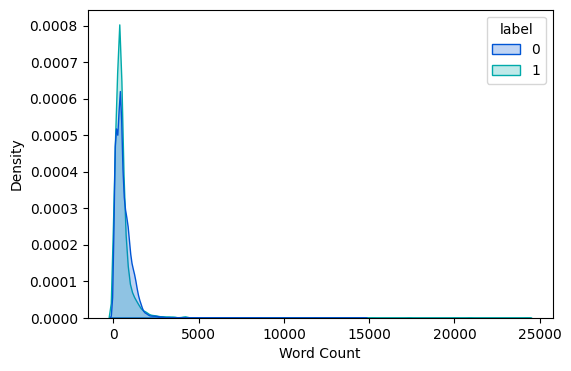

In [ ]:
plt.figure(figsize = (6, 4))
sns.kdeplot(x=news_df['text'].apply(lambda x:len(x.split())),
            hue=news_df['label'], palette='winter', fill=True)
plt.xlabel('Word Count')
plt.show()

In [ ]:
lengths = news_df['text'].apply(lambda x:len(x.split()))
np.percentile(lengths, 75)

670.0

In [ ]:
def wordcloud_text(text):
    plt.figure(figsize = (10, 8))
    wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  
                          background_color="black", colormap= 'viridis').generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [ ]:
real_text = " ".join(news_df[news_df['label'] == 1]['text'])
fake_text = " ".join(news_df[news_df['label'] == 0]['text'])

# Preproccesing

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

for row in news_df['text'].values:
    tmp = []
    sentences = nltk.sent_tokenize(row)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [ ]:
maxlen = int(np.percentile(lengths, 75))

w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=maxlen, window=5, min_count=1)

In [ ]:
w2v_model.save("fake_news.model")

In [ ]:
len(w2v_model.wv.index_to_key)

192801

In [ ]:
w2v_model.wv.most_similar('money')

[('cash', 0.6520571112632751),
 ('funds', 0.6053627729415894),
 ('donations', 0.5582549571990967),
 ('dollars', 0.5418856739997864),
 ('monies', 0.5367152094841003),
 ('dime', 0.5001481771469116),
 ('sums', 0.49575677514076233),
 ('profits', 0.4785405099391937),
 ('debts', 0.4763379395008087),
 ('fund', 0.46978604793548584)]

In [ ]:
def get_weight_matrix(model, vocab, maxlen):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, maxlen))
    
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]

    return weight_matrix

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [ ]:
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index, maxlen)

In [ ]:
y = news_df['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

# Model

In [ ]:
model = Sequential()

model.add(Embedding(len(tokenizer.word_index) + 1, 
                    output_dim=maxlen, 
                    weights=[embedding_vectors], 
                    input_length=maxlen, 
                    trainable=False))
#model.add(Conv1D(activation='relu', filters=4, kernel_size=4))
#model.add(MaxPool1D())
model.add(LSTM(units=128))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 670, 670)          129177340 
                                                                 
 lstm_1 (LSTM)               (None, 128)               409088    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 129,588,509
Trainable params: 411,169
No

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=5)

Epoch 1/5
742/742 [==============================] - 1297s 2s/step - loss: 0.2684 - acc: 0.8949 - val_loss: 0.2005 - val_acc: 0.9229
Epoch 2/5
742/742 [==============================] - 1329s 2s/step - loss: 0.1593 - acc: 0.9400 - val_loss: 0.1275 - val_acc: 0.9551
Epoch 3/5
742/742 [==============================] - 1285s 2s/step - loss: 0.1173 - acc: 0.9539 - val_loss: 0.1078 - val_acc: 0.9597
Epoch 4/5
742/742 [==============================] - 1294s 2s/step - loss: 0.0850 - acc: 0.9684 - val_loss: 0.1056 - val_acc: 0.9622
Epoch 5/5
742/742 [==============================] - 1339s 2s/step - loss: 0.0665 - acc: 0.9751 - val_loss: 0.1084 - val_acc: 0.9597


# Prediction

In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

354/354 [==============================] - 213s 602ms/step


In [ ]:
accuracy_score(y_test, y_pred)

0.9585029198371969